In [455]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import datetime as dt
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline 

# Steps:
1. Read and understand the data
2. Clean the data
3. Preparation of data 
4. Hopkins statistic to check  the dataset is suitable for clustering
5. Modelling 
6. Analysis and Business Recommendation


### 1. Read and understand the data

In [456]:
# Checking encoding type 
# import chardet
# with open('Online+Retail.csv','rb') as rawdata:
#     charType = chardet.detect(rawdata.read())

# print(charType)

In [457]:
# ISO-8859-1 is able to decode the dataset
df = pd.read_csv('Online+Retail.csv',encoding='ISO-8859-1')
df.shape

(541909, 8)

In [458]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom


In [459]:
df.tail(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.95,12680.0,France


In [460]:
df.info()
# we have missing values in 'Description' and 'CustomerID'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### 2. Cleaning the data 

In [461]:
# missing values 
round((df.isnull().sum() / df.shape[0]) * 100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [462]:
# Drop all rows containing null values
print('Total row before dropping',df.shape[0])
df = df.dropna()
print('Total row after dropping',df.shape[0])

Total row before dropping 541909
Total row after dropping 406829


In [463]:
# creat new column for total amount 
df['amount'] = df.Quantity * df.UnitPrice

### 3. Prepare the data for modelling

- R : (Recency ) > How recently was last transcation done
- F : (Frequency) > Frequency of tansaction last year
- M : (Monetory) > Total amount of revenure contributed by the customer

#### we have to convert our data columns into the following columns
For above dataset columns we required is 
-> 'cust_id', 'recency' , 'frequency' , 'monetory'

In [464]:
# Creating monetory column 
gm = df.groupby('CustomerID')['amount'].agg('sum')
gm = gm.reset_index()

In [465]:
# Frequency 
gf = df.groupby('CustomerID')['InvoiceNo'].agg('count')
gf = gf.reset_index()
gf.columns = ['CustomerID','Frequency']

In [466]:
# Merge both dataframe 
gf = pd.merge(left = gm,right = gf,on='CustomerID',how='inner')

In [467]:
gf.head(3)

,CustomerID,amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31


In [468]:
# Creating Recency  Column

# compute number of days since last transaction 
# 1. Convert 'InvoiceDate' column to DateTime object 
df.InvoiceDate =  pd.to_datetime(df.InvoiceDate,format='%d-%m-%Y %H:%M')
# 2. Compute max date
max_date = max(df.InvoiceDate)
# 3. Compute diffrence between maximum date and actual invoice date
df['diff'] = max_date  - df.InvoiceDate
# 4. group by csutomerID and find min value of diff
gr = df.groupby('CustomerID')['diff'].agg('min')
gr.reset_index()
# 5. Merge it with gf on customerID 
gf = pd.merge(left=gf,right=gr,on='CustomerID',how='inner')
# 6. Reupdate the column name
gf.columns = ['CustomerID','amount','frequency','recency']
gf.head(3)

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00


In [469]:
gf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   CustomerID  4372 non-null   float64        
 1   amount      4372 non-null   float64        
 2   frequency   4372 non-null   int64          
 3   recency     4372 non-null   timedelta64[ns]
dtypes: float64(2), int64(1), timedelta64[ns](1)
memory usage: 170.8 KB


In [470]:
# Remove time from recency column 
gf.recency = gf.recency.dt.days

<AxesSubplot:>

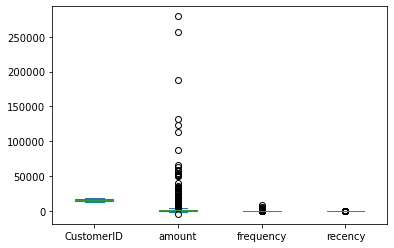

In [471]:
# Outlier Treatment 

# Two type of outliers:
    # a. Statistical Outliers  
    # b. Domain Specific Outliers
    
gf.plot(kind='box')
# amount contains outlier uqing IQR for removing outliers But , to accept them as outlier business
# domain knowledge/epertise is required 

In [472]:
# Removing statistical outliers {{ CUSTOM }}
print(gf.shape)
# For amount
Q1 = gf.amount.quantile(0.05)
Q3 = gf.amount.quantile(0.95)
IQR = Q3-Q1
gf = gf[(gf.amount >= Q1-1.5*IQR) & (gf.amount <= Q3+1.5*IQR)]
# For recency
Q1 = gf.recency.quantile(0.05)
Q3 = gf.recency.quantile(0.95)
IQR = Q3-Q1
gf = gf[(gf.recency >= Q1-1.5*IQR) & (gf.recency <= Q3+1.5*IQR)]
# For frequency
Q1 = gf.frequency.quantile(0.05)
Q3 = gf.frequency.quantile(0.95)
IQR = Q3-Q1
gf = gf[(gf.frequency >= Q1-1.5*IQR) & (gf.frequency <= Q3+1.5*IQR)]
 

(4372, 4)


In [473]:
# Rescaling
import sklearn 
from sklearn.preprocessing import StandardScaler 
# instantiate a scaler 
scaler = StandardScaler()
# perform rescaling on all three columns accept CustomerID 
# fit on scaler 
gf_scaled = pd.DataFrame(gf[['amount','frequency','recency']])
gf_scaled[['amount','frequency','recency']] = scaler.fit_transform(gf[['amount','frequency','recency']])
# now mean of each scaled variable is 0 and standard deviation is 1
gf_scaled.head(3)

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658


### 4. Hopkins statistic to check  the dataset is suitable for clustering

##### Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [474]:
from sklearn.neighbors import NearestNeighbors
from random import sample 
from numpy.random import uniform 
from math import isnan 

In [475]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [476]:
hopkins(gf_scaled)
# The dataset is suitable for clustering 

0.954857218189905

### 5. Modelling

In [477]:
from sklearn.cluster import KMeans

In [478]:
# k-means with some arbitary K 
kmeans = KMeans(n_clusters=4,max_iter=50)
kmeans.fit(gf_scaled)


KMeans(max_iter=50, n_clusters=4)

In [479]:
len(kmeans.labels_)

4293

### Optimal vlaue of K ie Clusters 

##### METHOD 1 : Elbow-Curve / Sum of Square Distance


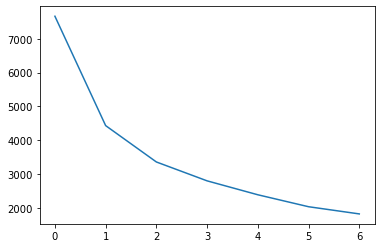

In [480]:

ssd= []
range_n_clusters=[2,3,4,5,6,7,8]
for num in range_n_clusters:
    kmeans = KMeans(n_clusters=num,max_iter=50)
    kmeans.fit(gf_scaled)
    ssd.append(kmeans.inertia_)

plt.plot(ssd)
# The graph show till cluster 3 thiers is significant decrease and after increasing 
# cluster to 4 and so on thiers is insignificant decrease in sum of square distance thus 
# the optimal value of cluster is 3.  Also must have domain/expertise for selecting K value

##### METHOD 2 : Silhouette Score / Silhouette Analysis 

slihouette score =  (p-q) / max(p,q)

p is the mean distance to the points in the nearest cluster that the data point is not a part of 

q is the mean intra-cluster distance to all the points in its own cluster

- The value of sihouette score range lies between -1 to 1 
- A score closer to 1 indicates the data point is very similar to other data points in the cluster
- A score closer to -1 indicates teh data point is not similar to other data points in the cluster     


In [481]:
# silhouette analysis
from sklearn.metrics import silhouette_score

for n in range_n_clusters:
    # init kmeans and do clustering
    kmeans = KMeans(n_clusters=n,max_iter=50)
    kmeans.fit(gf_scaled)
    # silhouette score 
    cluster_labels = kmeans.labels_
    avg_ss = silhouette_score(gf_scaled,cluster_labels)
    print('For n_cluster = {0},the silhouette score = {1}'.format(n,avg_ss))



For n_cluster = 2,the silhouette score = 0.5415858652525395
For n_cluster = 3,the silhouette score = 0.5084896296141937
For n_cluster = 4,the silhouette score = 0.4819356501012129
For n_cluster = 5,the silhouette score = 0.4651479014442592
For n_cluster = 6,the silhouette score = 0.41731693763654865
For n_cluster = 7,the silhouette score = 0.4148000729503976
For n_cluster = 8,the silhouette score = 0.4055102648496962


In [482]:
# final model with k = 3
kmeans = KMeans(n_clusters=3,max_iter=50)
kmeans.fit(gf_scaled)
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [483]:
# assign label to each customerID 
gf['clusterID'] = kmeans.labels_
gf.head()

,CustomerID,amount,frequency,recency,clusterID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


<AxesSubplot:xlabel='clusterID', ylabel='amount'>

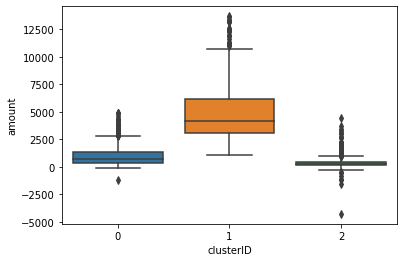

In [485]:
#plot
sns.boxplot(x='clusterID',y='amount',data=gf)

<AxesSubplot:xlabel='clusterID', ylabel='frequency'>

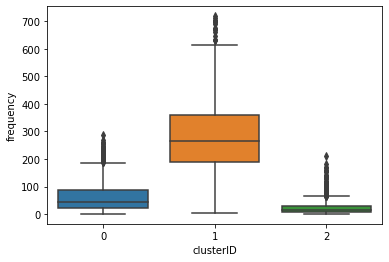

In [486]:
sns.boxplot(x='clusterID',y='frequency',data=gf)

<AxesSubplot:xlabel='clusterID', ylabel='recency'>

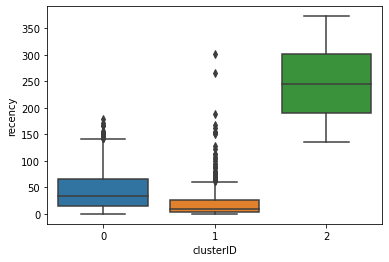

In [487]:
sns.boxplot(x='clusterID',y='recency',data=gf)